In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from tqdm.notebook import tqdm # A nice progress bar for notebooks

In [2]:
### setup code and library imports

In [3]:
# Set the path to your image directory. '.' means the current directory.
folder_path = '.'

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load the pre-trained ResNet50 model
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)

# 2. Remove the final classification layer (the 'fc' layer)
# We create a new model that is a sequence of all layers except the last one.
feature_extractor = nn.Sequential(*list(model.children())[:-1])

# 3. Set the model to evaluation mode and move it to the selected device
feature_extractor.to(device)
feature_extractor.eval() # This is crucial! It disables dropout/batch norm updates.

# 4. Define the image transformation pipeline
# This pipeline resizes, converts to a tensor, and normalizes the image
# to match the format the ResNet50 model was trained on.
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("PyTorch model and pre-processing pipeline are ready.")

Using device: cpu
PyTorch model and pre-processing pipeline are ready.


In [4]:
image_features_list = []
image_paths = []
batch_size = 32 # You can adjust this based on your system's RAM

# Get a list of all valid image files
valid_extensions = (".jpg", ".jpeg", ".png")
all_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)])
print(f"Found {len(all_files)} images to process.")

# Process images in batches
# The 'tqdm' wrapper will give us a nice progress bar
for i in tqdm(range(0, len(all_files), batch_size), desc="Extracting Features"):
    batch_paths = all_files[i:i+batch_size]
    batch_tensors = []

    # Load and preprocess all images in the current batch
    for filename in batch_paths:
        img_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            tensor = preprocess(img)
            batch_tensors.append(tensor)
            image_paths.append(img_path) # Store the valid path
        except Exception as e:
            print(f"Warning: Could not load image {img_path}. Skipping. Error: {e}")
            continue

    # Skip empty batches if all images in it failed to load
    if not batch_tensors:
        continue

    # Stack the list of tensors into a single batch tensor
    batch = torch.stack(batch_tensors).to(device)

    # Perform inference within the no_grad context for memory efficiency
    with torch.no_grad():
        features = feature_extractor(batch)
    
    # Flatten the features and move them to the CPU as NumPy arrays
    features_np = features.squeeze().cpu().numpy()
    
    # Handle the case of a single-item batch which might lose a dimension
    if features_np.ndim == 1:
        features_np = features_np.reshape(1, -1)
        
    image_features_list.extend(features_np)


# Convert the list of features into a single NumPy array
image_features = np.array(image_features_list)

print(f"\nFeature extraction complete. Extracted features for {len(image_features)} images.")
print(f"Shape of feature matrix: {image_features.shape}")

Found 200 images to process.


Extracting Features:   0%|          | 0/7 [00:00<?, ?it/s]


Feature extraction complete. Extracted features for 200 images.
Shape of feature matrix: (200, 2048)


In [18]:
### clustering

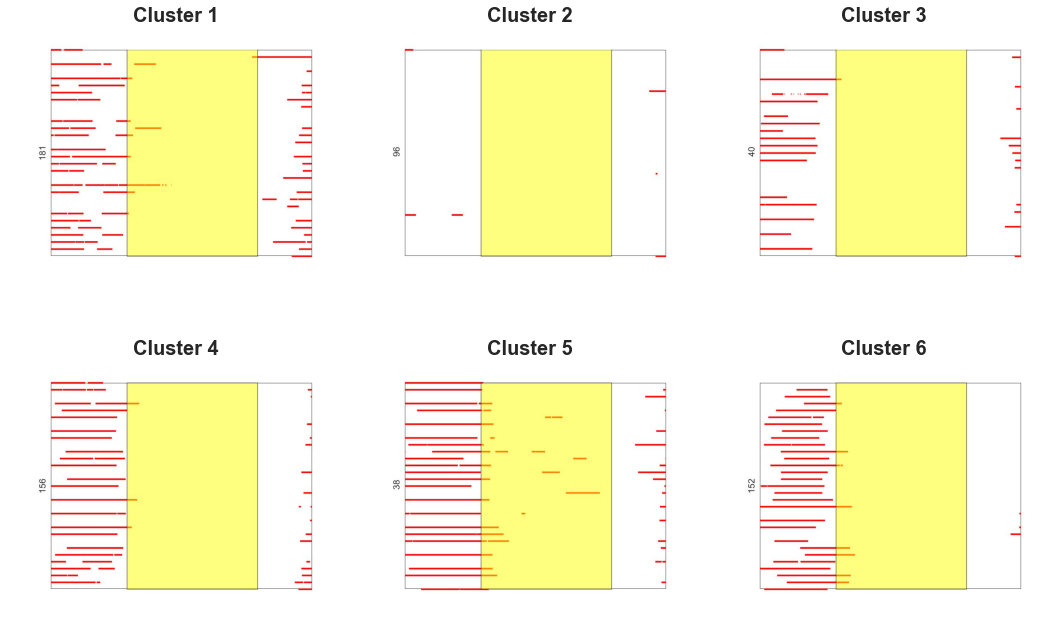

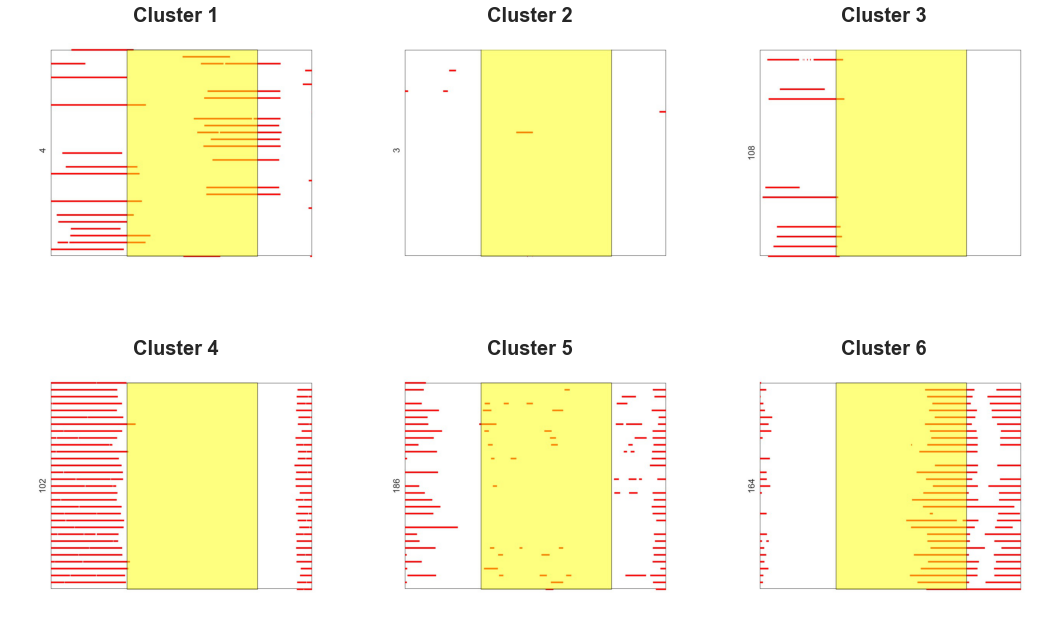

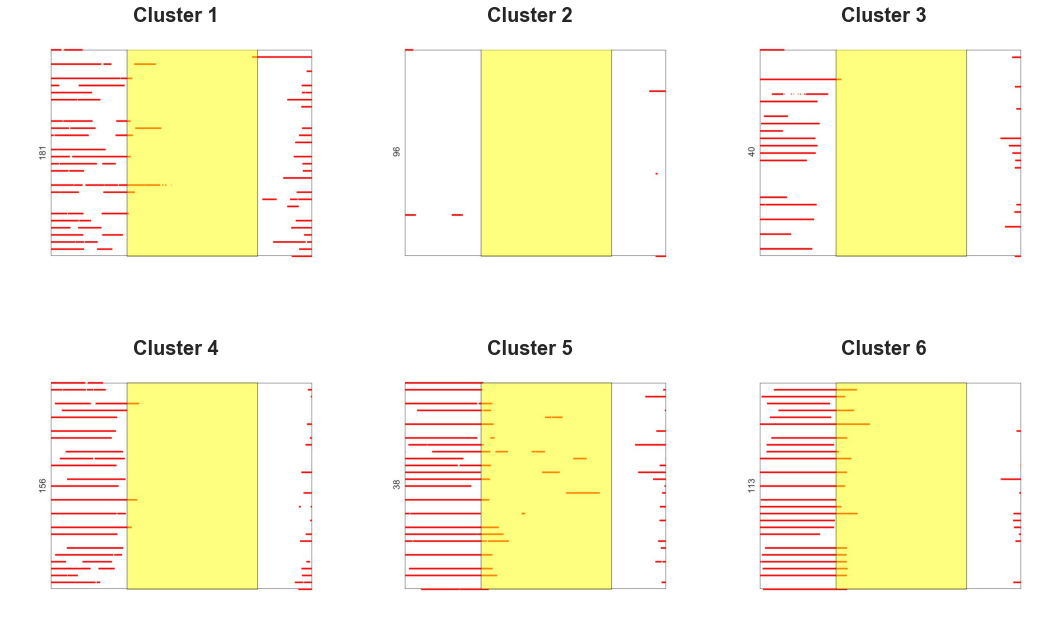


📋 REPRESENTATIVE IMAGE DETAILS

🎯 CENTROID METHOD (closest to mathematical center)
------------------------------------------------------------
  Cluster 1: figure1181.jpg
  Cluster 2: figure1096.jpg
  Cluster 3: figure1040.jpg
  Cluster 4: figure1156.jpg
  Cluster 5: figure1038.jpg
  Cluster 6: figure1152.jpg

⭐ DISTINCTIVE METHOD (farthest from other clusters)
------------------------------------------------------------
  Cluster 1: figure1004.jpg
  Cluster 2: figure1003.jpg
  Cluster 3: figure1108.jpg
  Cluster 4: figure1102.jpg
  Cluster 5: figure1186.jpg
  Cluster 6: figure1164.jpg

📍 MEDOID METHOD (center of cluster members)
------------------------------------------------------------
  Cluster 1: figure1181.jpg
  Cluster 2: figure1096.jpg
  Cluster 3: figure1040.jpg
  Cluster 4: figure1156.jpg
  Cluster 5: figure1038.jpg
  Cluster 6: figure1113.jpg

📊 CLUSTER SIZES:
------------------------------
  Cluster 1: 30 images
  Cluster 2: 19 images
  Cluster 3: 28 images
  Cluster 4: 

In [88]:
# Add these imports at the top (missing from your original code)
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import numpy as np

# Set random seeds for complete reproducibility
np.random.seed(43)
import random
random.seed(43)

# Set seaborn style for clean plots
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'font.size': 16
})

# Perform clustering
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(image_features)

# Create a DataFrame with results (convert labels to 1-6)
df = pd.DataFrame({
    'photo_name': [os.path.basename(path) for path in image_paths],
    'cluster': cluster_labels + 1  # Convert from 0-5 to 1-6
})

def find_representative_images(image_features, cluster_labels, image_paths, kmeans):
    """
    Find three types of representative images for each cluster:
    1. Centroid: closest to cluster center
    2. Most distinctive: farthest from other cluster centroids
    3. Medoid: smallest average distance to all other images in cluster
    """
    representative_images = {
        'centroid': {},
        'distinctive': {},
        'medoid': {}
    }
    
    for cluster_id in range(n_clusters):
        # Get indices of images in this cluster
        cluster_mask = cluster_labels == cluster_id
        cluster_data = image_features[cluster_mask]
        cluster_paths = np.array(image_paths)[cluster_mask]
        
        if len(cluster_data) == 0:
            continue
            
        cluster_num = cluster_id + 1  # Convert to 1-6 labeling
        
        # 1. CENTROID: Image closest to cluster center
        centroid = kmeans.cluster_centers_[cluster_id]
        centroid_distances = np.linalg.norm(cluster_data - centroid, axis=1)
        centroid_idx = np.argmin(centroid_distances)
        representative_images['centroid'][cluster_num] = cluster_paths[centroid_idx]
        
        # 2. MOST DISTINCTIVE: Image farthest from other cluster centroids
        if len(cluster_data) > 1:
            other_centroids = np.delete(kmeans.cluster_centers_, cluster_id, axis=0)
            distinctiveness_scores = []
            
            for img_idx, img_features in enumerate(cluster_data):
                # Calculate minimum distance to any other cluster centroid
                distances_to_others = np.linalg.norm(other_centroids - img_features, axis=1)
                min_distance_to_others = np.min(distances_to_others)
                distinctiveness_scores.append(min_distance_to_others)
            
            distinctive_idx = np.argmax(distinctiveness_scores)
            representative_images['distinctive'][cluster_num] = cluster_paths[distinctive_idx]
        else:
            # If only one image in cluster, it's both centroid and distinctive
            representative_images['distinctive'][cluster_num] = cluster_paths[0]
        
        # 3. MEDOID: Image with smallest average distance to all other images in cluster
        if len(cluster_data) > 1:
            avg_distances = []
            for i, img1 in enumerate(cluster_data):
                distances = [np.linalg.norm(img1 - img2) for j, img2 in enumerate(cluster_data) if i != j]
                avg_distances.append(np.mean(distances))
            
            medoid_idx = np.argmin(avg_distances)
            representative_images['medoid'][cluster_num] = cluster_paths[medoid_idx]
        else:
            # If only one image in cluster, it's the medoid
            representative_images['medoid'][cluster_num] = cluster_paths[0]
    
    return representative_images

def show_method_grids(df, folder_path, image_features, cluster_labels, image_paths, kmeans):
    """
    Display three separate 2x3 grids, one for each method
    """
    # Find all representative images
    representative_images = find_representative_images(image_features, cluster_labels, image_paths, kmeans)
    
    methods = ['centroid', 'distinctive', 'medoid']
    
    for method in methods:
        # Create 2x3 grid for this method
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        for cluster_num in range(1, n_clusters + 1):
            ax = axes[cluster_num - 1]  # Convert to 0-5 indexing
            
            if cluster_num in representative_images[method]:
                img_path = representative_images[method][cluster_num]
                img = Image.open(img_path)
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f'Cluster {cluster_num}', fontsize=20, fontweight='bold', pad=10)
            else:
                ax.axis('off')
                ax.set_title(f'Cluster {cluster_num}', fontsize=20, fontweight='bold', pad=10)
        
        plt.tight_layout()
        plt.show()

# Display three separate 2x3 grids for each method
show_method_grids(df, folder_path, image_features, cluster_labels, image_paths, kmeans)

# Detailed information about each method
representative_images = find_representative_images(image_features, cluster_labels, image_paths, kmeans)

print("\n" + "="*70)
print("📋 REPRESENTATIVE IMAGE DETAILS")
print("="*70)

methods_info = {
    'centroid': '🎯 CENTROID METHOD (closest to mathematical center)',
    'distinctive': '⭐ DISTINCTIVE METHOD (farthest from other clusters)', 
    'medoid': '📍 MEDOID METHOD (center of cluster members)'
}

for method, description in methods_info.items():
    print(f"\n{description}")
    print("-" * 60)
    for cluster_num in range(1, n_clusters + 1):
        if cluster_num in representative_images[method]:
            img_name = os.path.basename(representative_images[method][cluster_num])
            print(f"  Cluster {cluster_num}: {img_name}")
        else:
            print(f"  Cluster {cluster_num}: No image found")

print(f"\n📊 CLUSTER SIZES:")
print("-" * 30)
for cluster_num in range(1, n_clusters + 1):
    cluster_size = len(df[df['cluster'] == cluster_num])
    print(f"  Cluster {cluster_num}: {cluster_size} images")

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETE")
print("="*70)

In [77]:
### show all images in clusters

In [ ]:
### optimized smaller jpeg images same quality

Creating individual cluster JPEG images...
Cluster 1: 30 images
  ✅ Saved JPEG: cluster_1.jpg (696.8 KB)
     Confirmed: cluster_1.jpg is a valid JPEG file


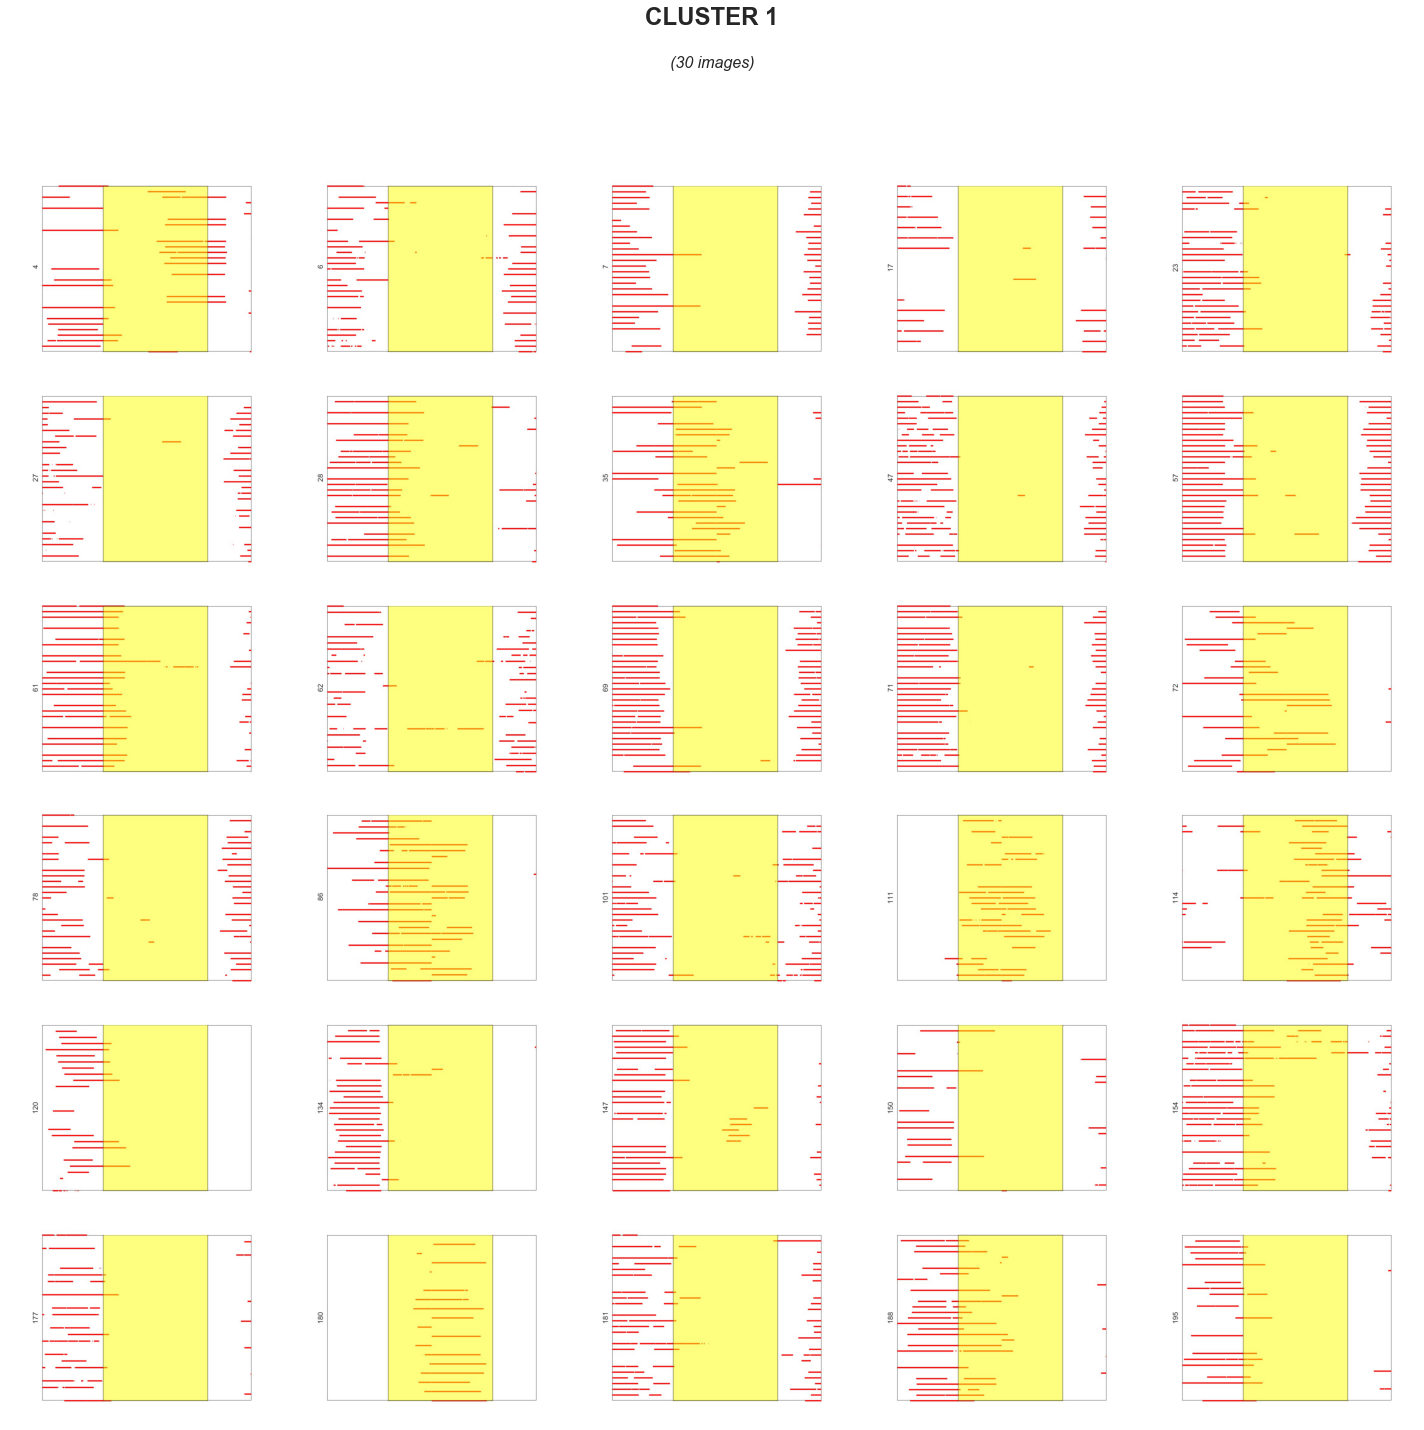

Cluster 2: 19 images
  ✅ Saved JPEG: cluster_2.jpg (187.0 KB)
     Confirmed: cluster_2.jpg is a valid JPEG file


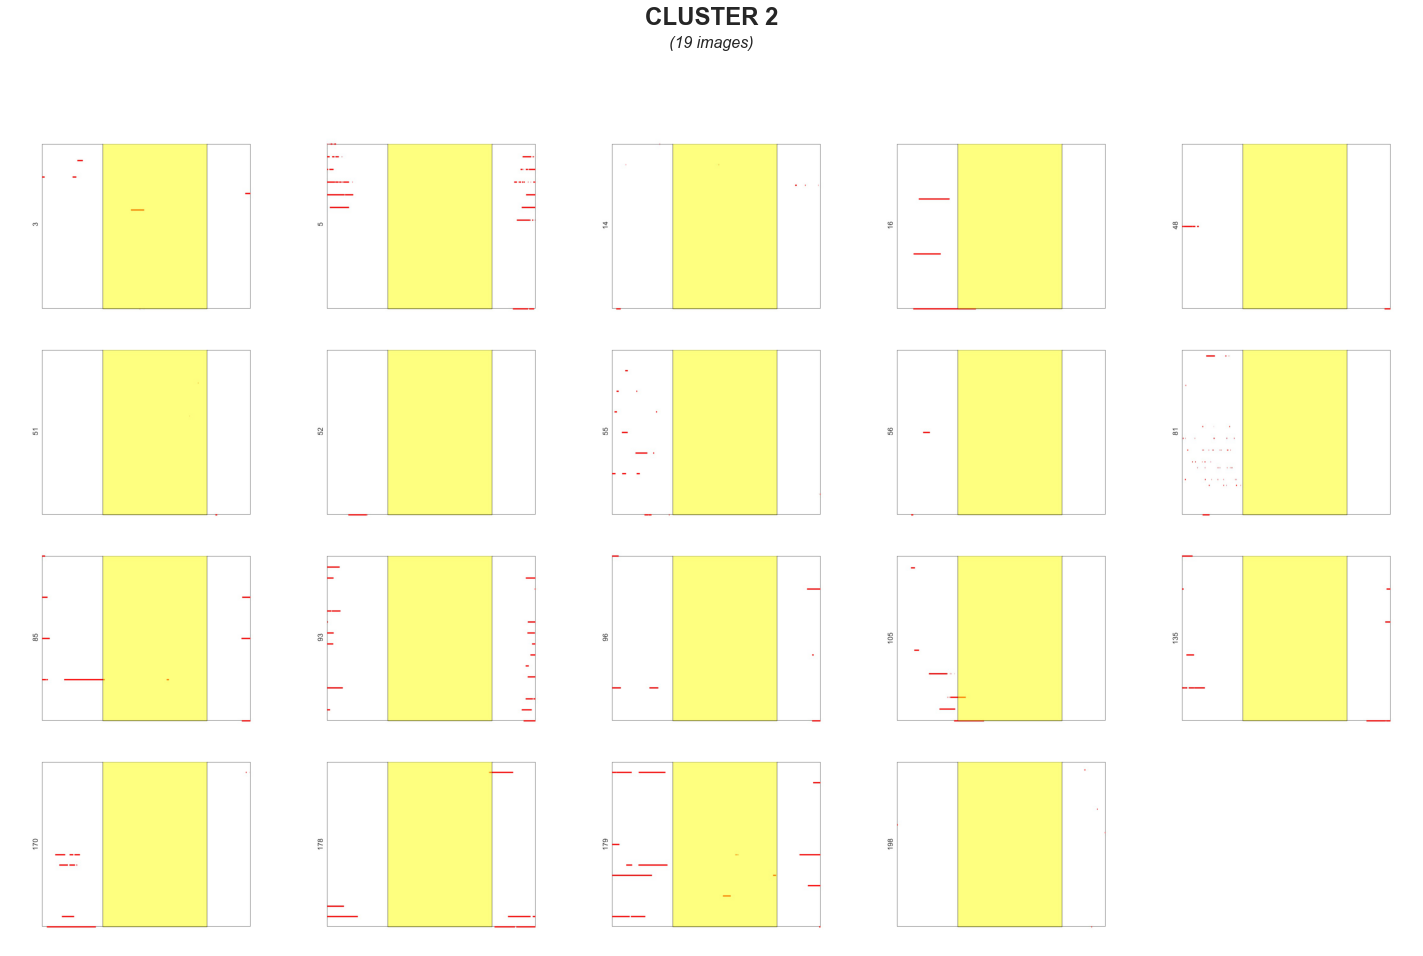

Cluster 3: 28 images
  ✅ Saved JPEG: cluster_3.jpg (492.4 KB)
     Confirmed: cluster_3.jpg is a valid JPEG file


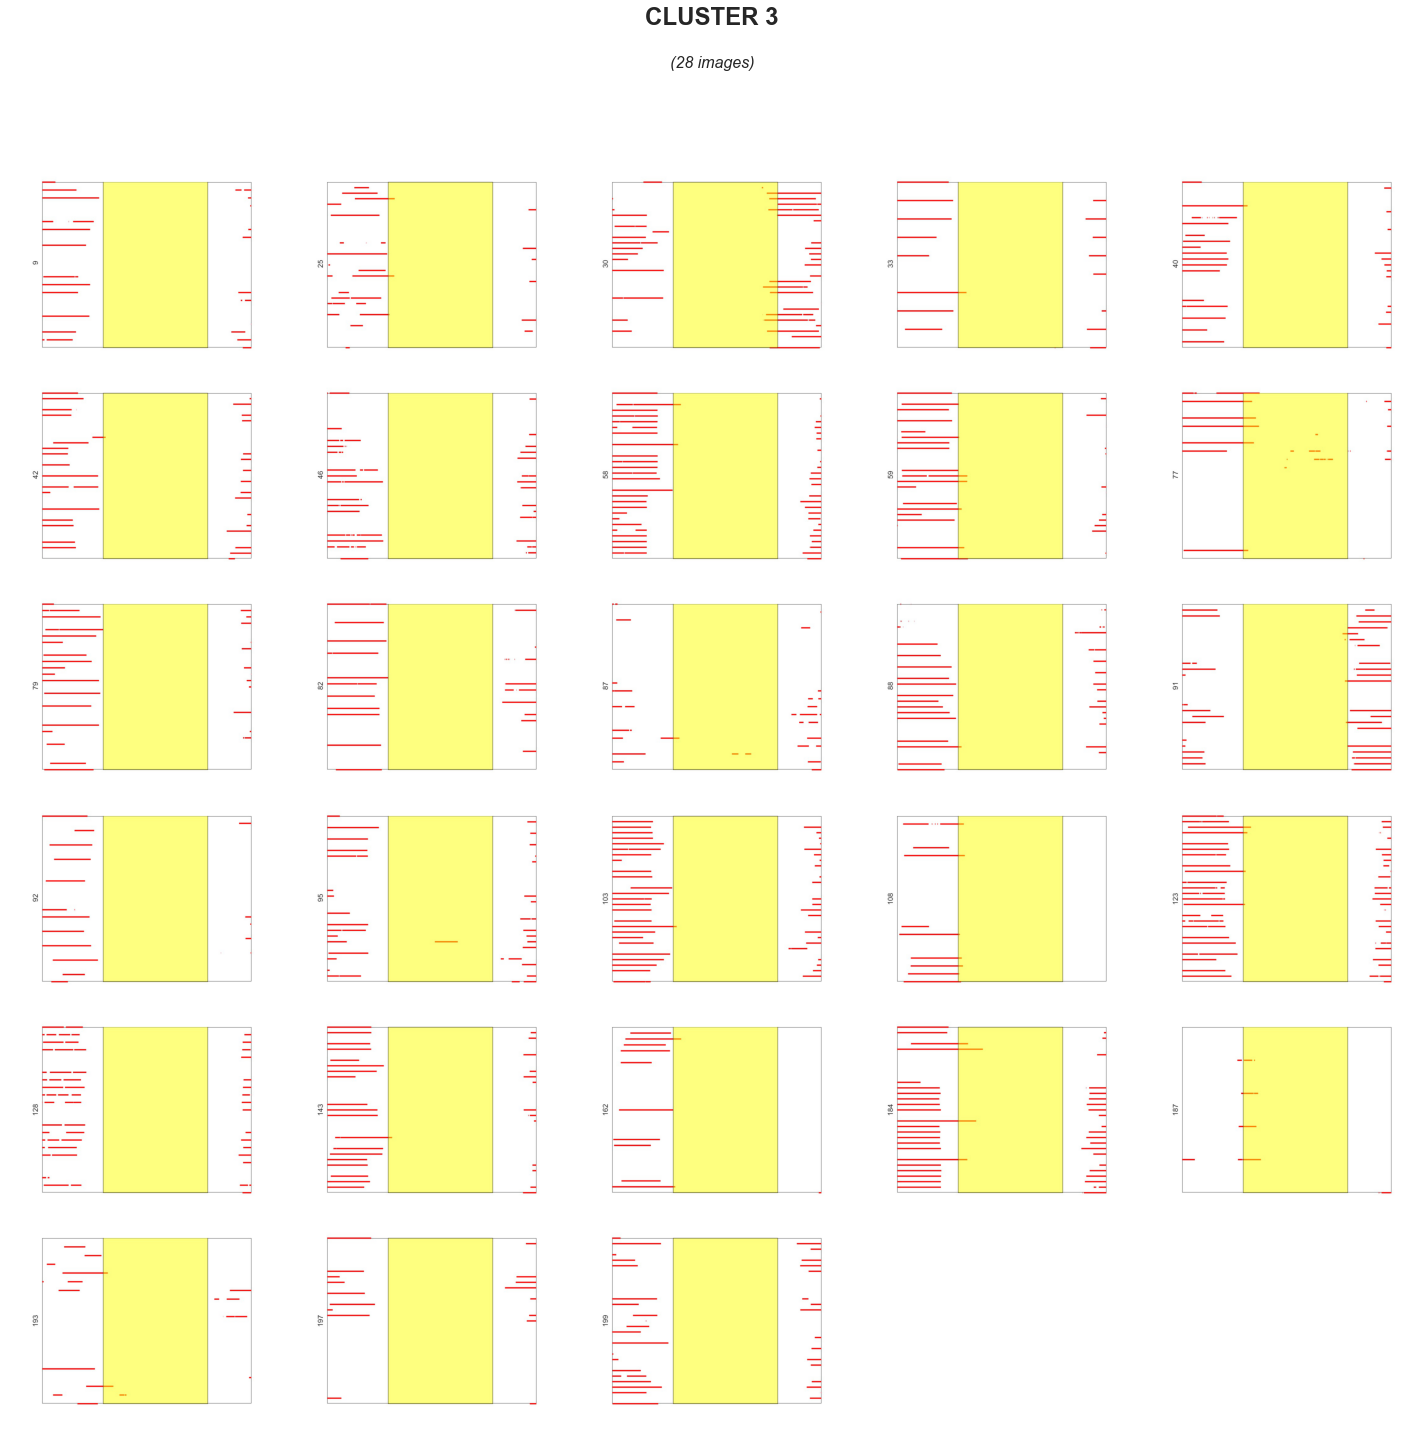

Cluster 4: 51 images
  ✅ Saved JPEG: cluster_4_part_1.jpg (610.1 KB)
     Confirmed: cluster_4_part_1.jpg is a valid JPEG file


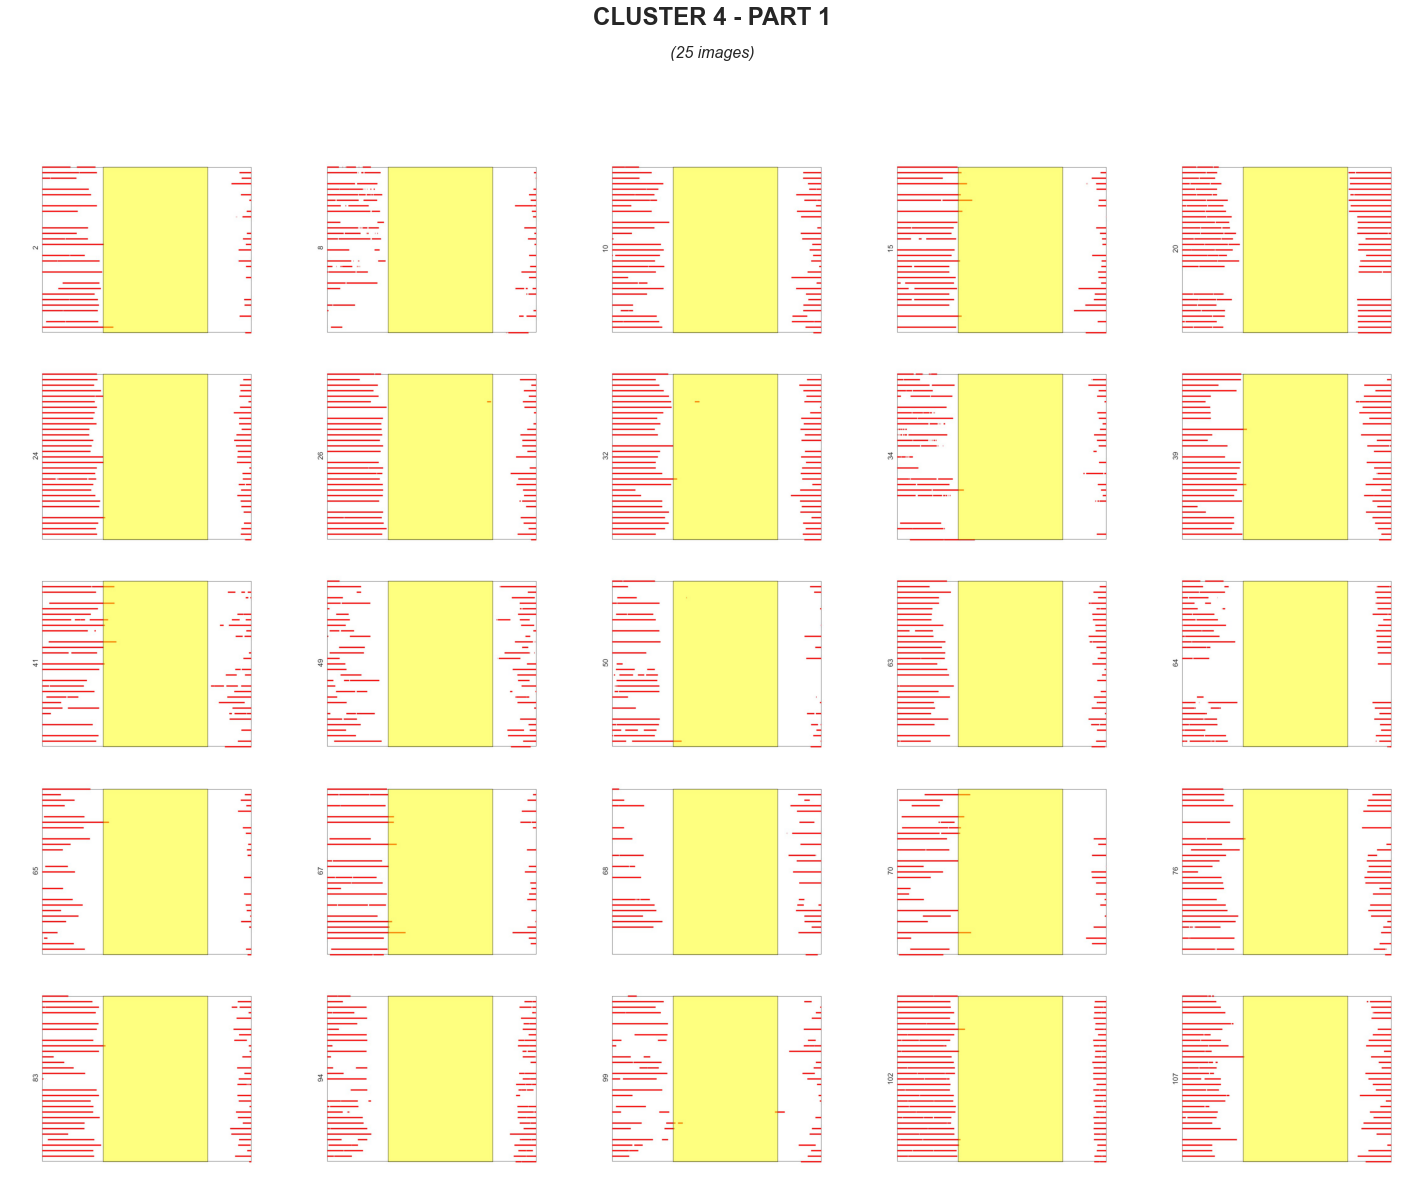

  ✅ Saved JPEG: cluster_4_part_2.jpg (621.2 KB)
     Confirmed: cluster_4_part_2.jpg is a valid JPEG file


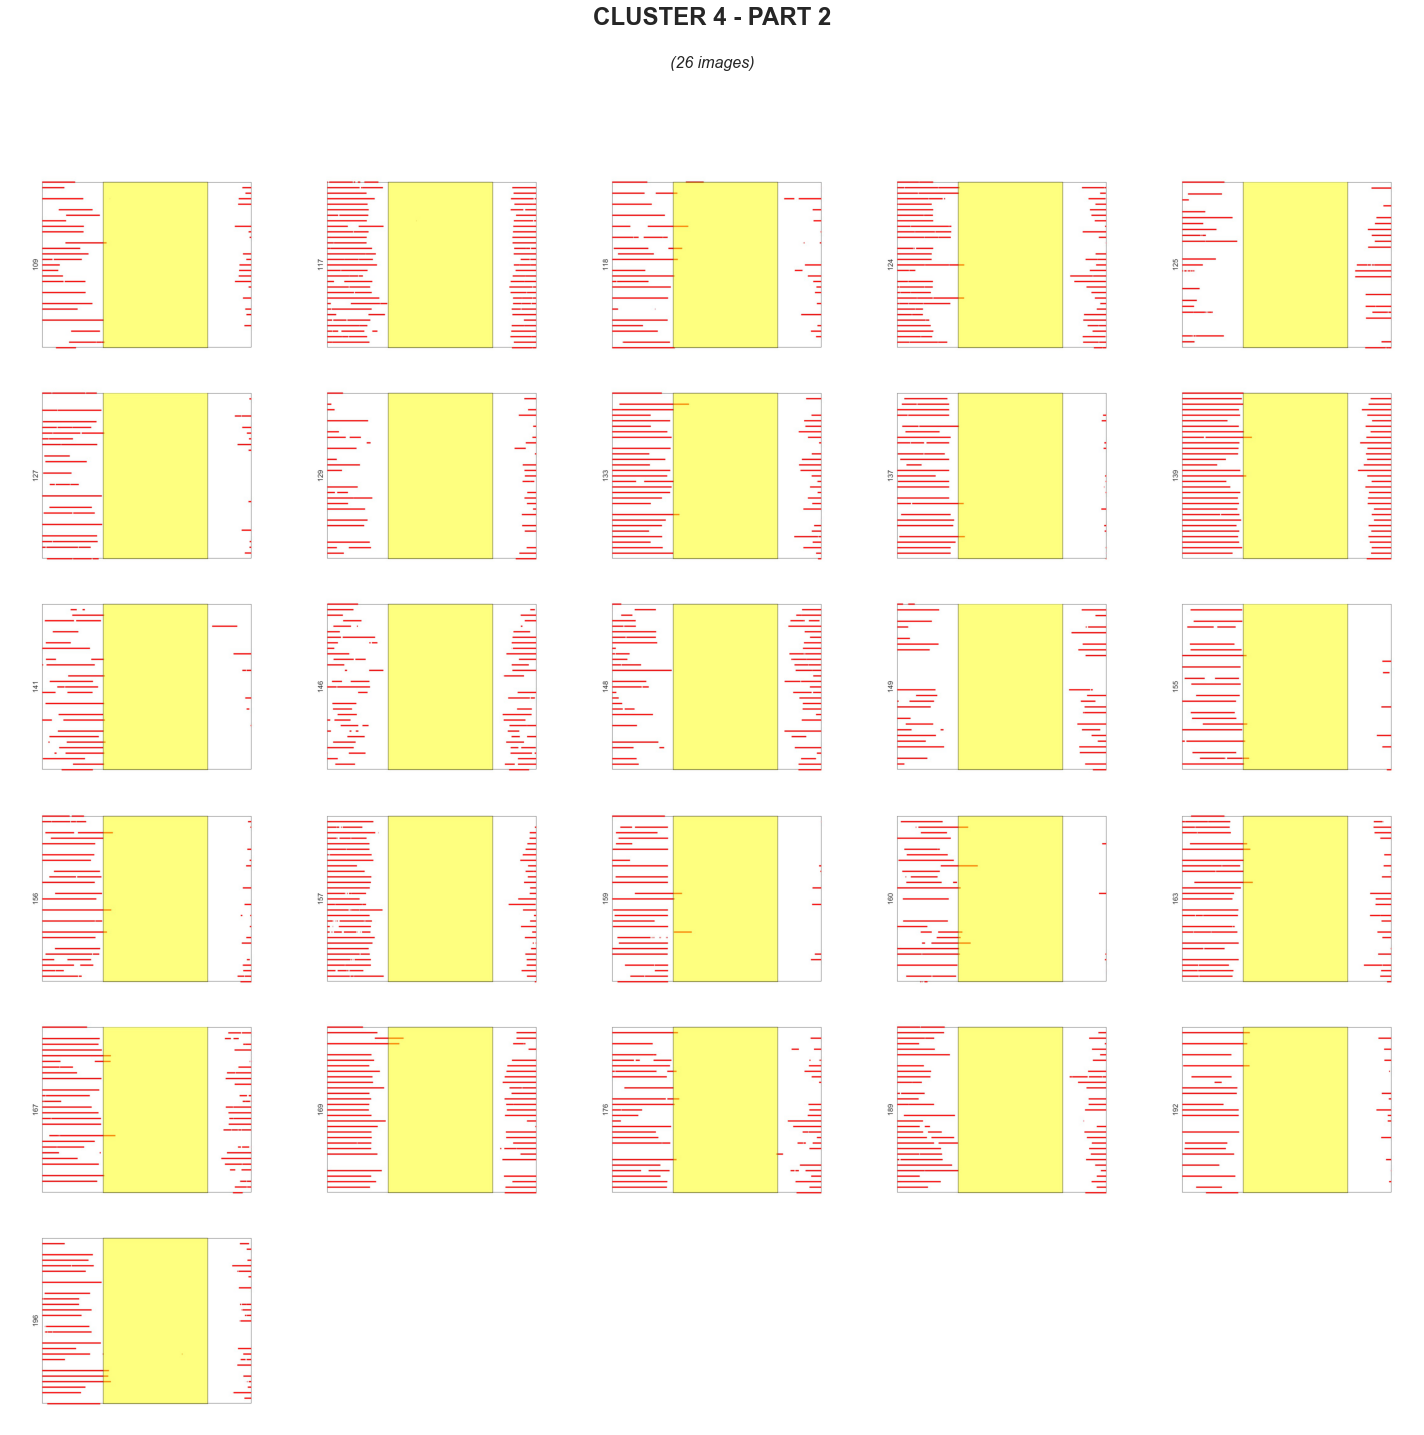

Cluster 5: 20 images
  ✅ Saved JPEG: cluster_5.jpg (581.7 KB)
     Confirmed: cluster_5.jpg is a valid JPEG file


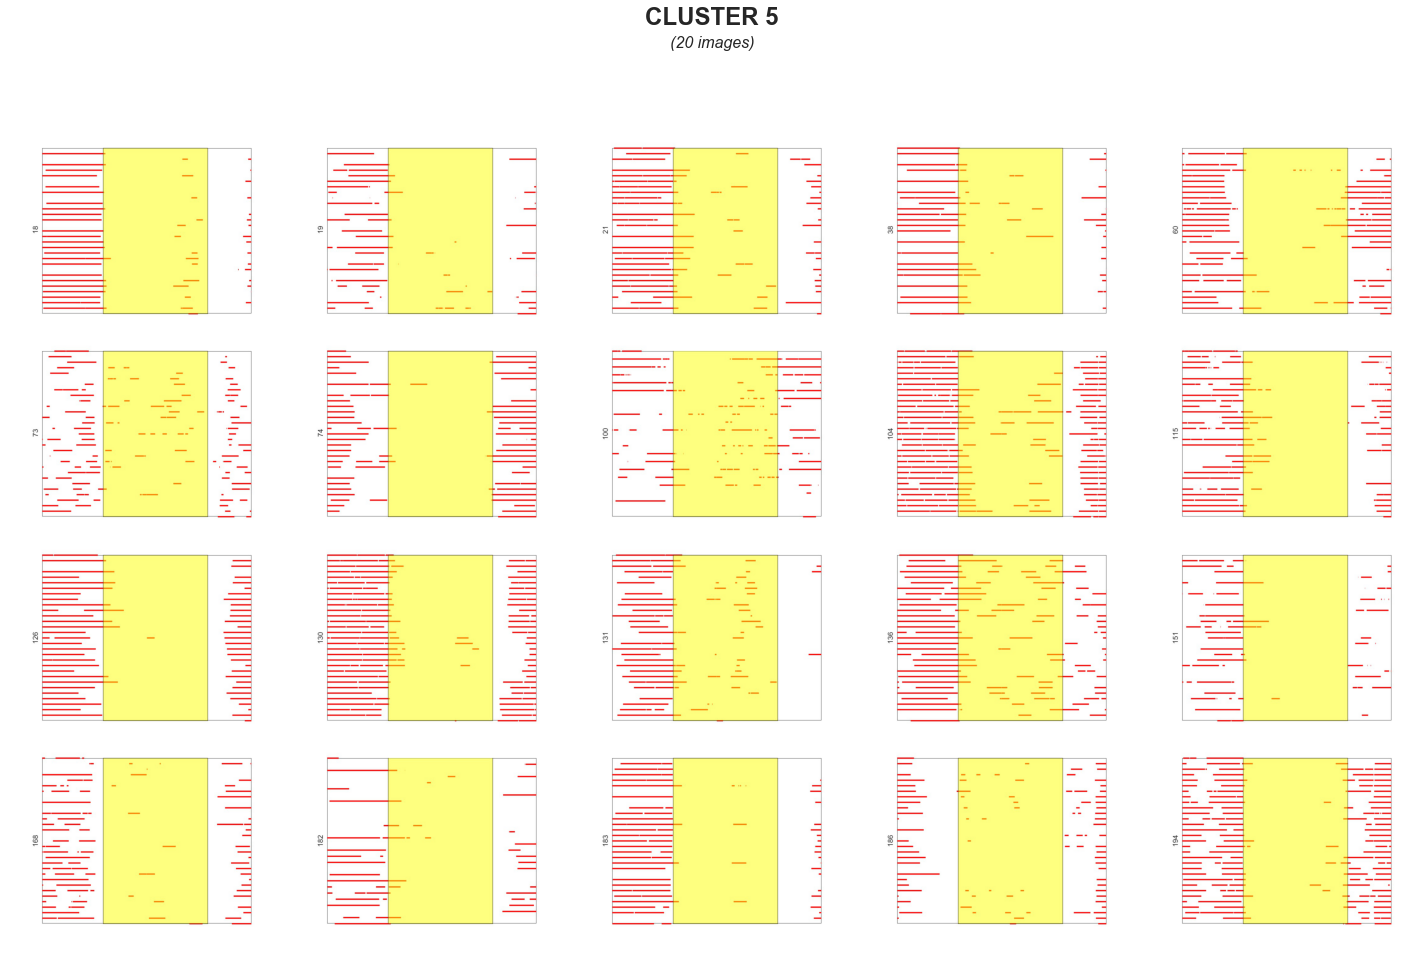

Cluster 6: 52 images
  ✅ Saved JPEG: cluster_6_part_1.jpg (678.3 KB)
     Confirmed: cluster_6_part_1.jpg is a valid JPEG file


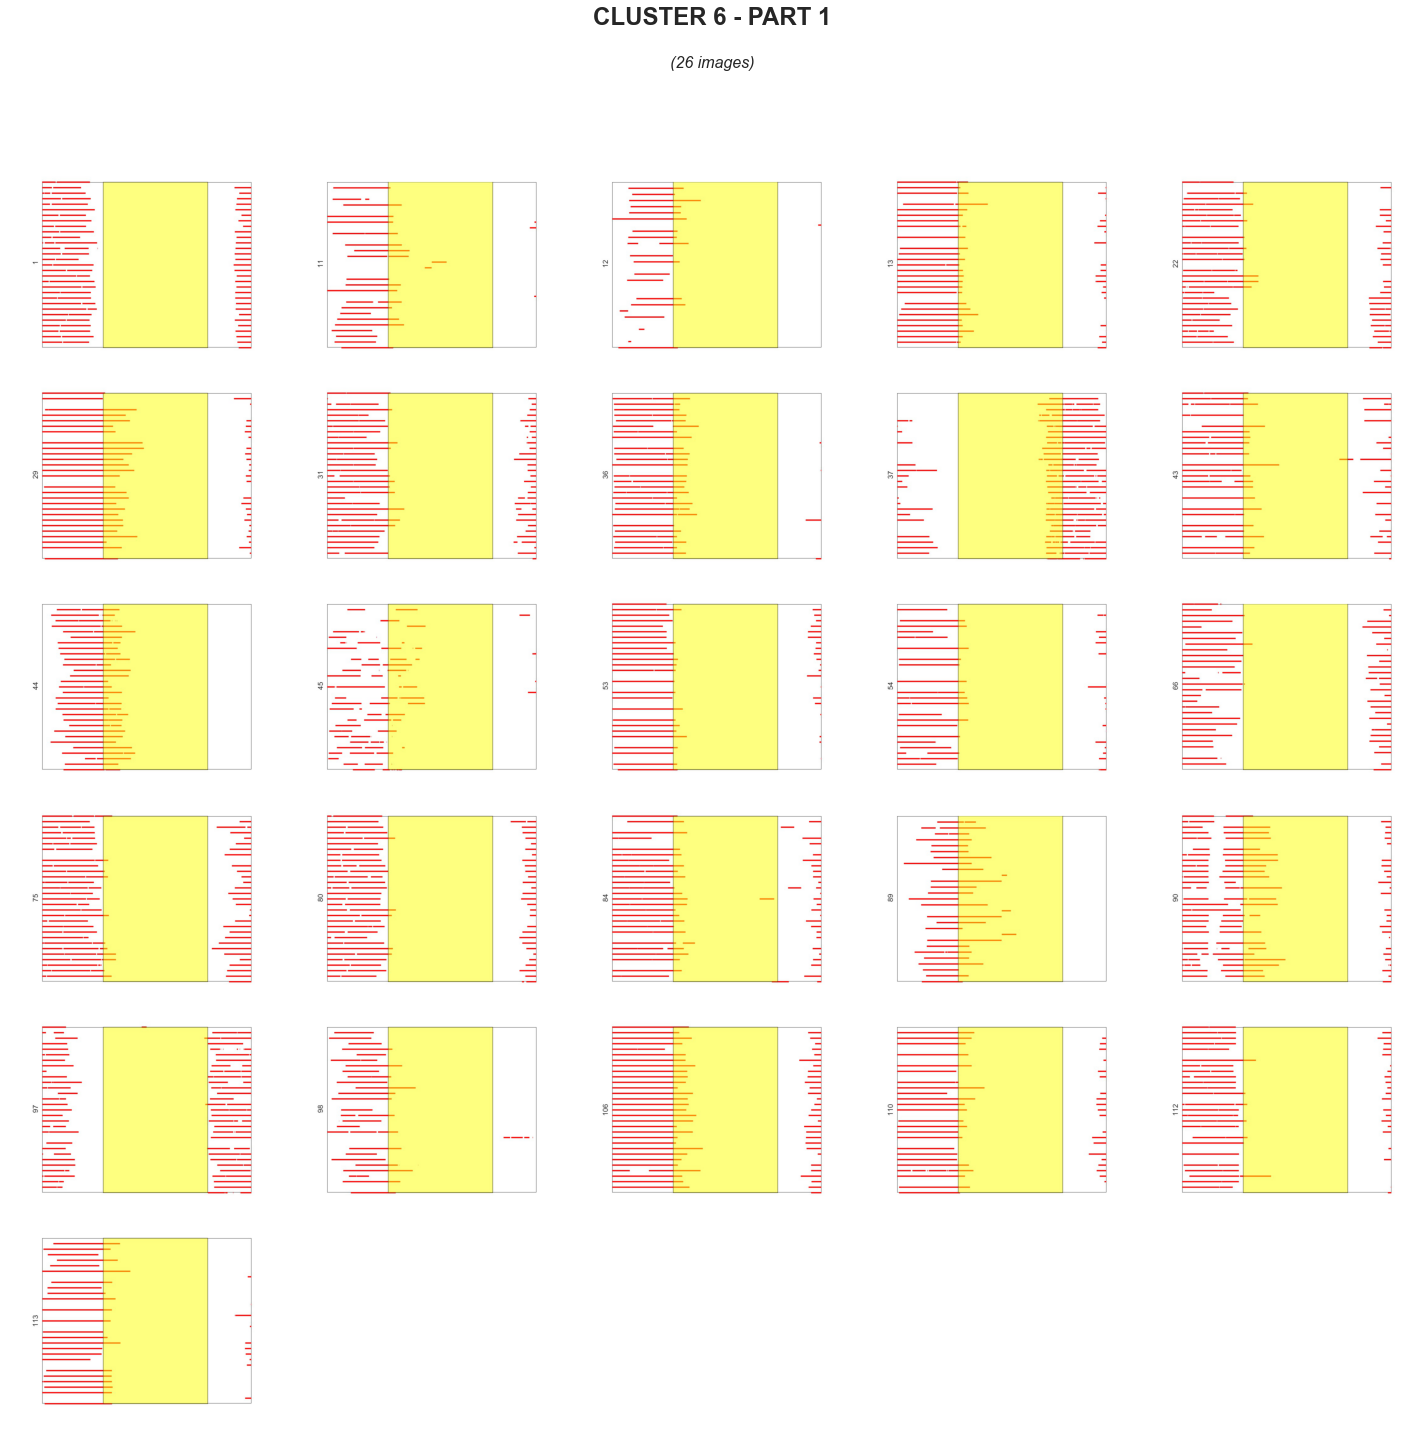

  ✅ Saved JPEG: cluster_6_part_2.jpg (643.2 KB)
     Confirmed: cluster_6_part_2.jpg is a valid JPEG file


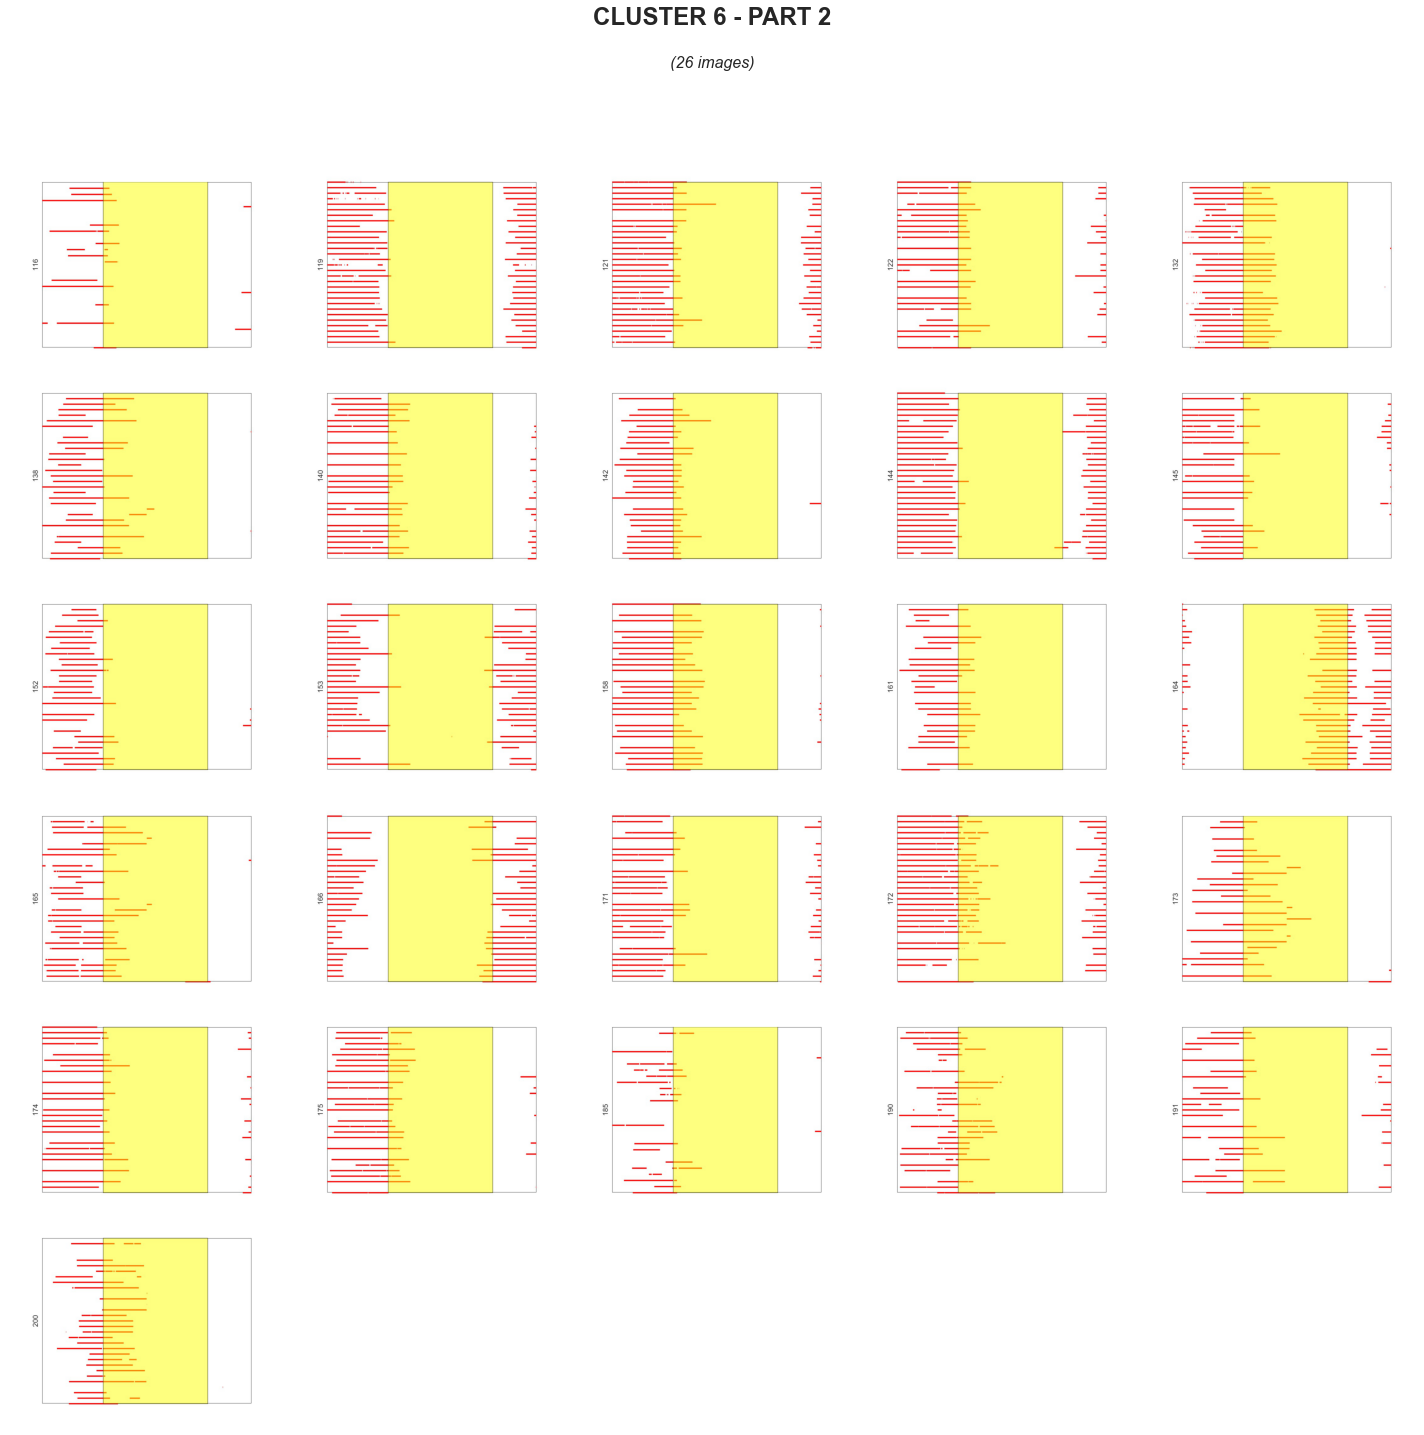

✅ All cluster JPEG images saved!


In [35]:
# Set random seeds
np.random.seed(43)
import random
random.seed(43)
import os
from PIL import Image
import io

def save_clusters_individually(image_paths, cluster_labels, n_clusters=7, max_images_per_file=30, n_cols=5, save_prefix="cluster"):
    """
    Save each cluster as its own JPEG image file(s) in a 5-column grid
    
    Parameters:
    - image_paths: list of image file paths
    - cluster_labels: cluster assignments for each image
    - n_clusters: number of clusters (default 6)
    - max_images_per_file: max images before splitting into multiple files (default 30)
    - n_cols: number of columns per grid (default 5)
    - save_prefix: prefix for saved files (default "cluster")
    """
    # Organize images by cluster
    cluster_images = {i: [] for i in range(1, n_clusters + 1)}
    
    for img_path, cluster_id in zip(image_paths, cluster_labels):
        cluster_num = cluster_id + 1  # Convert from 0-5 to 1-6
        cluster_images[cluster_num].append(img_path)
    
    print("Creating individual cluster JPEG images...")
    print("=" * 50)
    
    # Process each cluster
    for cluster_num in range(1, n_clusters + 1):
        cluster_imgs = cluster_images[cluster_num]
        n_images = len(cluster_imgs)
        
        if n_images == 0:
            print(f"Cluster {cluster_num}: No images - skipping")
            continue
        
        print(f"Cluster {cluster_num}: {n_images} images")
        
        # Determine if we need to split this cluster
        if n_images <= max_images_per_file:
            # Single file for this cluster
            _save_cluster_grid_jpeg(cluster_imgs, cluster_num, 1, 1, n_cols, save_prefix)
        else:
            # Split into 2 files
            mid_point = n_images // 2
            
            # First half
            first_half = cluster_imgs[:mid_point]
            _save_cluster_grid_jpeg(first_half, cluster_num, 1, 2, n_cols, save_prefix)
            
            # Second half
            second_half = cluster_imgs[mid_point:]
            _save_cluster_grid_jpeg(second_half, cluster_num, 2, 2, n_cols, save_prefix)
    
    print("=" * 50)
    print("✅ All cluster JPEG images saved!")

def _save_cluster_grid_jpeg(images, cluster_num, part_num, total_parts, n_cols, save_prefix):
    """
    Helper function to save a single cluster grid as JPEG
    """
    n_images = len(images)
    n_rows = (n_images + n_cols - 1) // n_cols  # Calculate rows needed
    
    # Create figure with appropriate size
    fig_width = n_cols * 4  # 4 inches per column
    fig_height = max(n_rows * 3.5, 6)  # 3.5 inches per row, minimum 6
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    
    # Handle single row case
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    # Create title
    if total_parts == 1:
        title = f"CLUSTER {cluster_num}"
        subtitle = f"({n_images} images)"
    else:
        title = f"CLUSTER {cluster_num} - PART {part_num}"
        subtitle = f"({n_images} images)"
    
    # Add title with proper spacing
    fig.suptitle(title, fontsize=24, fontweight='bold', y=0.95)
    fig.text(0.5, 0.91, subtitle, ha='center', fontsize=16, style='italic')
    
    # Display each image
    for i in range(n_images):
        img_path = images[i]
        img = Image.open(img_path)
        
        row_idx = i // n_cols
        col_idx = i % n_cols
        ax = axes[row_idx, col_idx]
        
        ax.imshow(img)
        ax.axis('off')
    
    # Hide unused subplots
    for i in range(n_images, len(axes_flat)):
        axes_flat[i].axis('off')
    
    # Adjust layout with proper spacing
    plt.tight_layout(rect=[0, 0, 1, 0.88])  # Leave space for title
    
    # Generate filename with .jpg extension
    if total_parts == 1:
        filename = f"{save_prefix}_{cluster_num}.jpg"
    else:
        filename = f"{save_prefix}_{cluster_num}_part_{part_num}.jpg"
    
    # Force save as JPEG with high quality at 150 DPI
    # First save as buffer, then save as high-quality JPEG
    buf = io.BytesIO()
    fig.savefig(buf, dpi=150, format='jpeg', 
               bbox_inches='tight', facecolor='white', pad_inches=0.2)
    buf.seek(0)
    
    # Use PIL to save with specific quality
    final_img = Image.open(buf)
    final_img.save(filename, 'JPEG', quality=95, optimize=True)
    buf.close()
    
    # Verify the file was created and check its properties
    if os.path.exists(filename):
        file_size = os.path.getsize(filename) / 1024  # Size in KB
        print(f"  ✅ Saved JPEG: {filename} ({file_size:.1f} KB)")
        
        # Double-check file type
        with open(filename, 'rb') as f:
            header = f.read(3)
            if header == b'\xff\xd8\xff':
                print(f"     Confirmed: {filename} is a valid JPEG file")
            else:
                print(f"     ⚠️  Warning: {filename} may not be a proper JPEG file")
    else:
        print(f"  ❌ Error: Failed to create {filename}")
    
    plt.show()
    plt.close()  # Close to free memory

# Set clean font parameters globally (removed invalid parameters)
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'font.size': 14,
    'axes.titlesize': 16,
    'figure.titlesize': 24
})

# Usage: Save each cluster as individual JPEG image files
save_clusters_individually(image_paths, cluster_labels, n_clusters=7, max_images_per_file=30, n_cols=5)

# Alternative usage examples:
# save_clusters_individually(image_paths, cluster_labels, max_images_per_file=20)  # Split at 20 images
# save_clusters_individually(image_paths, cluster_labels, n_cols=4)  # Use 4 columns instead

In [ ]:
### cluster testing and metric rankings

In [70]:
### focused 4 metrics

Creating placeholder image_features with shape (200, 2048)...
STEP 1: GOLD-STANDARD OUTLIER REMOVAL
Original data shape: (200, 2048)
Isolation Forest identified and removed 5 outliers.
Cleaned data shape for validation: (195, 2048)
--------------------------------------------------------------------------------
Running PCA on cleaned data...
PCA transformed data shape: (195, 124) (retaining 95.0% of variance)
--------------------------------------------------------------------------------

--- Starting Validation Run 1/10 (seed=0) ---

--- Starting Validation Run 2/10 (seed=1) ---

--- Starting Validation Run 3/10 (seed=2) ---

--- Starting Validation Run 4/10 (seed=3) ---

--- Starting Validation Run 5/10 (seed=4) ---

--- Starting Validation Run 6/10 (seed=5) ---

--- Starting Validation Run 7/10 (seed=6) ---

--- Starting Validation Run 8/10 (seed=7) ---

--- Starting Validation Run 9/10 (seed=8) ---

--- Starting Validation Run 10/10 (seed=9) ---

          META-ANALYSIS OF FOCUSED

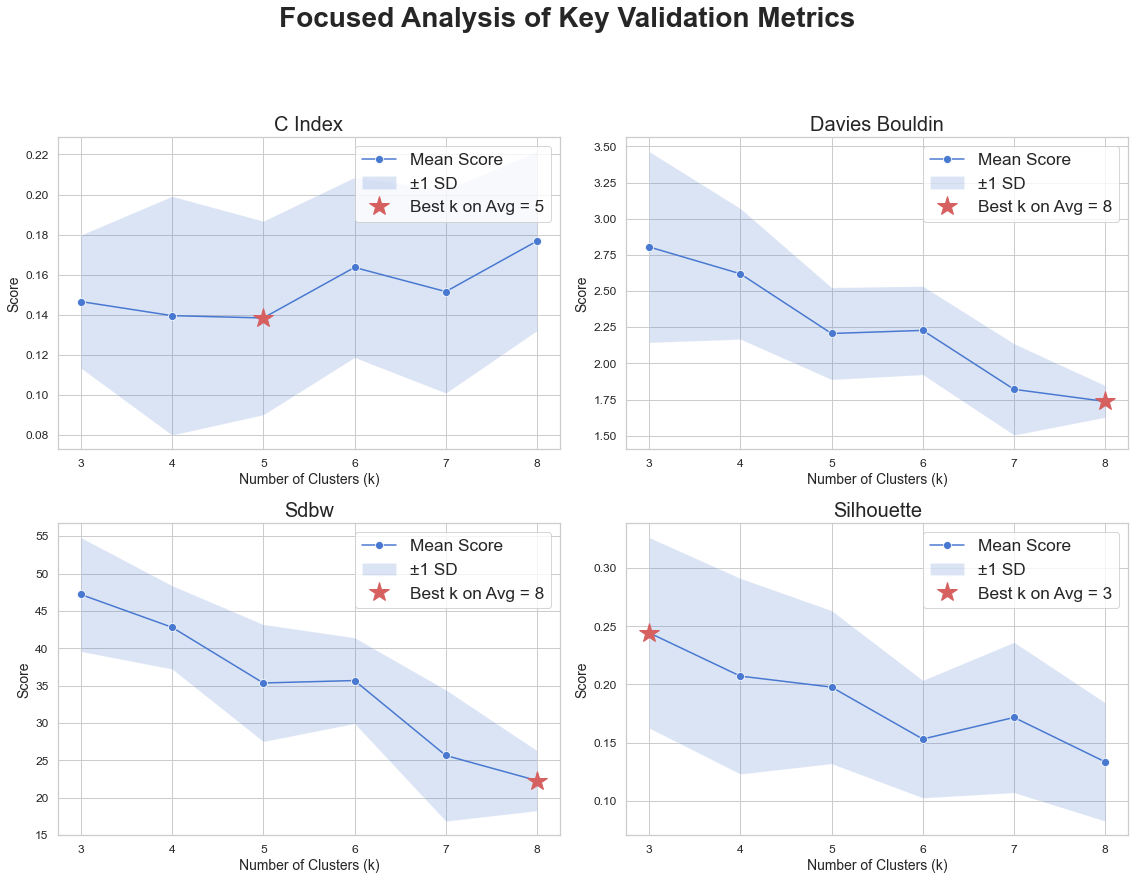


--- Final Recommendation Calculation ---
The final recommendation is the rounded average of the 'best k' from the four selected metrics.
Calculation: (3 + 5 + 8 + 8) / 4 = 6.00 ≈ 6

FINAL FOCUSED RECOMMENDATION
Individual Metric Recommendations (from averaged scores):
  - C Index             : k = 5
  - Davies Bouldin      : k = 8
  - Sdbw                : k = 8
  - Silhouette          : k = 3

Based on the average of these specific metrics, the final recommended
number of clusters is: k = 6


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import (silhouette_score, davies_bouldin_score)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from scipy.spatial.distance import cdist, pdist
from kneed import KneeLocator
import warnings
warnings.filterwarnings('ignore')

class FocusedValidator:
    """
    A lightweight validator focused on calculating a specific set of four key metrics:
    Silhouette, C-Index, Davies-Bouldin, and SDBW.
    """
    def __init__(self, data, min_nc=2, max_nc=10, seed=42):
        self.data = data
        self.min_nc = min_nc
        self.max_nc = max_nc
        self.k_range = range(min_nc, max_nc + 1)
        self.seed = seed
        self.indices = {}
        self.best_k = {}
        
    def calculate_indices(self):
        """Calculates only the four specified metrics."""
        # Initialize dictionaries
        for name in ['silhouette', 'c_index', 'davies_bouldin', 'sdbw']:
            self.indices[name] = {k: np.nan for k in self.k_range}

        for k in self.k_range:
            model = KMeans(n_clusters=k, random_state=self.seed, n_init=10)
            labels = model.fit_predict(self.data)
            centers = model.cluster_centers_
            
            # --- Calculate only the 4 specified metrics ---
            if k > 1:
                self._add_index('silhouette', k, silhouette_score(self.data, labels))
                self._add_index('davies_bouldin', k, davies_bouldin_score(self.data, labels))
                self._add_index('c_index', k, self._c_index(self.data, labels))
                self._add_index('sdbw', k, self._sdbw_validity(self.data, labels, centers))
                
        self._find_best_k()
        return self.indices, self.best_k

    def _add_index(self, name, k, value):
        self.indices[name][k] = value

    # --- Helper methods required for the 4 metrics ---
    def _c_index(self, X, labels):
        dists = pdist(X)
        n_w = sum(sum(labels == i) * (sum(labels == i) - 1) // 2 for i in np.unique(labels))
        if n_w == 0: return 0.0
        s = sum(pdist(X[labels == i]).sum() for i in np.unique(labels) if sum(labels == i) > 1)
        s_min = np.sort(dists)[:n_w].sum()
        s_max = np.sort(dists)[-n_w:].sum()
        return (s - s_min) / (s_max - s_min) if s_max > s_min else 0.0

    def _sdbw_validity(self, X, labels, centers):
        if len(centers) == 0: return np.inf
        scat = sum(np.linalg.norm(np.std(X[labels == i], axis=0)) for i in range(len(centers))) / len(centers)
        dens_bw = 0
        if len(centers) > 1:
            for i in range(len(centers)):
                for j in range(i + 1, len(centers)):
                    u_ij = (centers[i] + centers[j]) / 2
                    std_i = np.linalg.norm(np.std(X[labels == i], axis=0)) if len(X[labels == i]) > 1 else 0
                    std_j = np.linalg.norm(np.std(X[labels == j], axis=0)) if len(X[labels == j]) > 1 else 0
                    max_std = max(std_i, std_j)
                    if max_std == 0: continue
                    density_i = sum(1 for x in X[labels == i] if np.linalg.norm(x - u_ij) <= max_std)
                    density_j = sum(1 for x in X[labels == j] if np.linalg.norm(x - u_ij) <= max_std)
                    dens_bw += (density_i + density_j) / (len(X[labels == i]) + len(X[labels == j]))
            return scat + dens_bw / (len(centers)*(len(centers)-1)/2)
        return scat

    def _find_best_k(self):
        criteria = {'silhouette': 'max', 'c_index': 'min', 'davies_bouldin': 'min', 'sdbw': 'min'}
        for name, values in self.indices.items():
            if name not in criteria or not values: self.best_k[name] = "N/A"; continue
            k_values = sorted(values.keys())
            scores = [values[k] for k in values]
            if not any(np.isfinite(s) for s in scores): self.best_k[name] = "N/A"; continue
            try:
                if criteria[name] == 'max': self.best_k[name] = k_values[np.nanargmax(scores)]
                elif criteria[name] == 'min': self.best_k[name] = k_values[np.nanargmin(scores)]
            except (ValueError, TypeError): self.best_k[name] = "N/A"

def aggregate_runs(all_run_indices, k_range, metric_names):
    long_form_data = []
    for i, run_indices in enumerate(all_run_indices):
        for metric_name, k_scores in run_indices.items():
            for k, score in k_scores.items():
                long_form_data.append({'run': i, 'metric': metric_name, 'k': k, 'score': score})
    agg_df = pd.DataFrame(long_form_data)
    agg_stats = agg_df.groupby(['metric', 'k'])['score'].agg(['mean', 'std']).reset_index()
    agg_stats.rename(columns={'mean': 'score_mean', 'std': 'score_std'}, inplace=True)
    averaged_indices = {}
    for metric_name in metric_names:
        metric_data = agg_stats[agg_stats['metric'] == metric_name]
        averaged_indices[metric_name] = pd.Series(metric_data.score_mean.values, index=metric_data.k).to_dict()
    return averaged_indices, agg_stats

def plot_focused_metrics(agg_df, best_k_on_average):
    print("\n--- Generating Focused 2x2 Plot of Key Metrics ---")
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
    
    metrics_to_plot = sorted(agg_df['metric'].unique())
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    fig.suptitle("Focused Analysis of Key Validation Metrics", fontsize=28, fontweight='bold', y=1.02)
    
    for i, name in enumerate(metrics_to_plot):
        ax = axes[i]
        metric_data = agg_df[agg_df['metric'] == name]
        
        sns.lineplot(data=metric_data, x='k', y='score_mean', ax=ax, marker='o', markersize=8, label='Mean Score')
        ax.fill_between(metric_data['k'], metric_data['score_mean'] - metric_data['score_std'], 
                        metric_data['score_mean'] + metric_data['score_std'], alpha=0.2, label='±1 SD')
        
        if name in best_k_on_average and best_k_on_average[name] != "N/A":
            best_k = best_k_on_average[name]
            mean_score_at_best_k = metric_data[metric_data['k'] == best_k]['score_mean'].mean()
            if np.isfinite(mean_score_at_best_k):
                ax.plot(best_k, mean_score_at_best_k, 'r*', markersize=20, label=f'Best k on Avg = {best_k}')
        
        ax.set_title(name.replace('_', ' ').title(), fontsize=20)
        ax.set_xlabel('Number of Clusters (k)', fontsize=14)
        ax.set_ylabel('Score', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.legend(loc='best', fontsize='large')
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    filename = "focused_4_metric_analysis.jpg"
    print(f"Saving plot to '{filename}'...")
    plt.savefig(filename, dpi=150, format='jpeg', bbox_inches='tight')
    plt.show()

def perform_focused_validation(features, num_runs=10, min_clusters=2, max_clusters=10, pca_variance_to_keep=0.95):
    print("="*80); print("STEP 1: GOLD-STANDARD OUTLIER REMOVAL"); print("="*80)
    scaler_outlier = StandardScaler(); features_scaled_outlier = scaler_outlier.fit_transform(features)
    iso_forest = IsolationForest(contamination='auto', random_state=42); outlier_preds = iso_forest.fit_predict(features_scaled_outlier)
    is_inlier = outlier_preds == 1; num_outliers = np.sum(outlier_preds == -1)
    features_cleaned = features[is_inlier, :]
    print(f"Original data shape: {features.shape}"); print(f"Isolation Forest identified and removed {num_outliers} outliers.")
    print(f"Cleaned data shape for validation: {features_cleaned.shape}"); print("-" * 80)
    
    scaler = StandardScaler(); features_scaled_pca = scaler.fit_transform(features_cleaned)
    print(f"Running PCA on cleaned data...")
    pca = PCA(n_components=pca_variance_to_keep, random_state=42); features_pca = pca.fit_transform(features_scaled_pca)
    print(f"PCA transformed data shape: {features_pca.shape} (retaining {pca_variance_to_keep*100:.1f}% of variance)\n" + "-" * 80)
    
    focused_metrics = ['silhouette', 'c_index', 'davies_bouldin', 'sdbw']
    all_run_indices = []
    for i in range(num_runs):
        print(f"\n--- Starting Validation Run {i+1}/{num_runs} (seed={i}) ---")
        validator = FocusedValidator(features_pca, min_clusters, max_clusters, seed=i)
        indices, _ = validator.calculate_indices()
        all_run_indices.append(indices)
        
    print("\n" + "="*80); print("          META-ANALYSIS OF FOCUSED METRICS"); print("="*80)
    k_range = range(min_clusters, max_clusters + 1)
    averaged_indices, agg_df = aggregate_runs(all_run_indices, k_range, focused_metrics)
    
    temp_validator = FocusedValidator(features_pca, min_clusters, max_clusters)
    temp_validator.indices = averaged_indices
    temp_validator._find_best_k()
    best_k_on_average = temp_validator.best_k

    plot_focused_metrics(agg_df, best_k_on_average)
    
    # Final recommendation based on the average of the 4 metrics' best k
    recommendations = [v for v in best_k_on_average.values() if isinstance(v, (int, np.integer))]
    if not recommendations:
        final_recommendation = "N/A"
        print("Could not determine a final recommendation as no metrics succeeded.")
    else:
        final_recommendation = int(round(np.mean(recommendations)))
        
    print("\n--- Final Recommendation Calculation ---")
    print("The final recommendation is the rounded average of the 'best k' from the four selected metrics.")
    rec_str = " + ".join(map(str, recommendations))
    print(f"Calculation: ({rec_str}) / {len(recommendations)} = {np.mean(recommendations):.2f} ≈ {final_recommendation}")
    
    return final_recommendation, best_k_on_average

# --- Example Usage ---
if __name__ == "__main__":
    print("Creating placeholder image_features with shape (200, 2048)...")
#     image_features = np.random.rand(200, 2048)
    
    final_k, individual_recs = perform_focused_validation(
        features=image_features, 
        num_runs=10, 
        min_clusters=3, 
        max_clusters=8, 
        pca_variance_to_keep=0.95
    )
    
    print(f"\n{'='*80}"); print("FINAL FOCUSED RECOMMENDATION"); print(f"{'='*80}")
    print("Individual Metric Recommendations (from averaged scores):")
    for metric, k in sorted(individual_recs.items()):
        print(f"  - {metric.replace('_', ' ').title():<20}: k = {k}")
    
    print(f"\nBased on the average of these specific metrics, the final recommended")
    print(f"number of clusters is: k = {final_k}")
    print(f"{'='*80}")

In [12]:
### tsne calcs

Data loaded. 'image_features' and 'image_paths' are ready.

Running K-Means and t-SNE...


/Users/latherialcalbert/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Clustering and t-SNE complete.

GENERATING FLIPPED PORTRAIT PLOT

--- Running DYNAMIC Force-Directed Layout (Orientation: portrait_flipped) ---
Step 1: Selecting exactly 250 random images.
   -> Rotating data to flipped portrait mode.
Step 2: Starting physics simulation for 200 images...
   -> Layout iteration 0/500...
   -> Layout iteration 25/500...
   -> Layout iteration 50/500...
   -> Layout iteration 75/500...
   -> Layout iteration 100/500...
   -> Layout iteration 125/500...
   -> Layout iteration 150/500...
   -> Layout iteration 175/500...
   -> Layout iteration 200/500...
   -> Layout iteration 225/500...
   -> Layout iteration 250/500...
   -> Layout iteration 275/500...
   -> Layout iteration 300/500...
   -> Layout iteration 325/500...
   -> Layout iteration 350/500...
   -> Layout iteration 375/500...
   -> Layout iteration 400/500...
   -> Layout iteration 425/500...
   -> Layout iteration 450/500...
   -> Layout iteration 475/500...
Simulation complete. Finalizing plot

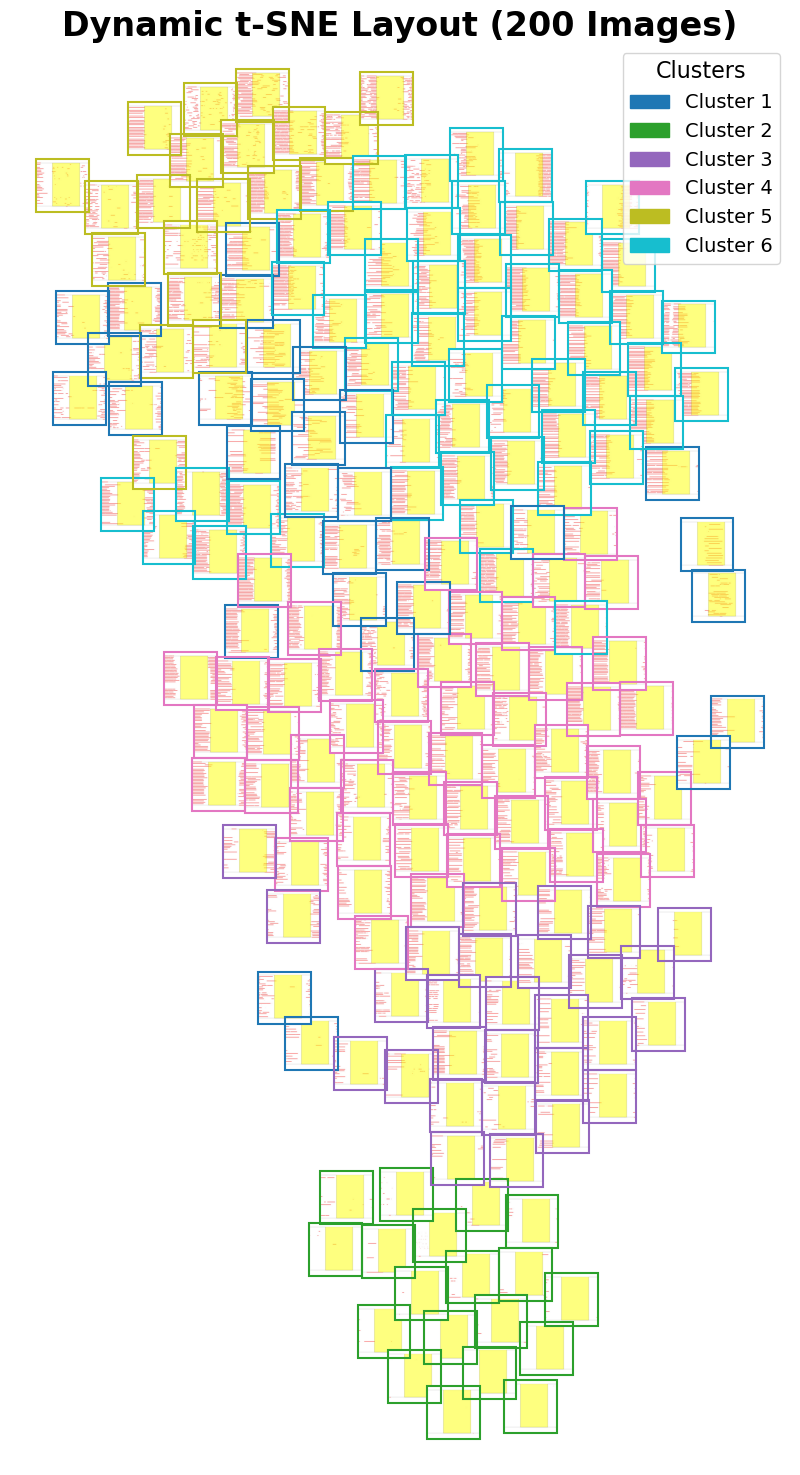

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle, Patch

# ==============================================================================
# 0. SETUP: Load your data here
# ==============================================================================
if 'image_features' not in locals() or 'image_paths' not in locals():
    raise NameError("Error: 'image_features' and 'image_paths' are not defined. "
                    "Please load your data before running this script.")
print("Data loaded. 'image_features' and 'image_paths' are ready.")


# ==============================================================================
# 1. CLUSTERING & T-SNE
# ==============================================================================
print("\nRunning K-Means and t-SNE...")
np.random.seed(42)
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(image_features)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, init='pca', learning_rate='auto')
tsne_results = tsne.fit_transform(image_features)
print("Clustering and t-SNE complete.")


# ==============================================================================
# 2. HELPER FUNCTION: To crop images
# ==============================================================================
def center_crop_to_square(img):
    width, height = img.size
    min_dim = min(width, height)
    left, top = (width - min_dim) // 2, (height - min_dim) // 2
    right, bottom = (width + min_dim) // 2, (height + min_dim) // 2
    return img.crop((left, top, right, bottom))


# ==============================================================================
# 3. VISUALIZATION LOGIC: Dynamic Layout
# ==============================================================================
def visualize_tsne_dynamic(tsne_results, image_paths, cluster_labels, n_clusters,
                           num_images_to_display=200,
                           image_size_multiplier=1.5,
                           iterations=100,
                           learning_rate=0.1,
                           dpi=100,
                           outline_thickness=3,
                           orientation='landscape'):
    """
    Visualizes t-SNE using a force-directed algorithm with full aesthetic control.

    Args:
        ...
        orientation (str): 'landscape' (default), 'portrait', or 'portrait_flipped'.
    """
    print(f"\n--- Running DYNAMIC Force-Directed Layout (Orientation: {orientation}) ---")
    
    # --- Step 1: Image selection ---
    print(f"Step 1: Selecting exactly {num_images_to_display} random images.")
    if num_images_to_display > len(image_paths):
        num_images_to_display = len(image_paths)

    np.random.seed(42)
    selected_indices = np.random.choice(len(image_paths), num_images_to_display, replace=False)
    
    positions = tsne_results[selected_indices]
    paths = [image_paths[i] for i in selected_indices]
    labels = cluster_labels[selected_indices]
    num_selected = len(selected_indices)

    # --- NEW: Handle All Orientations ---
    if orientation == 'portrait':
        print("   -> Rotating data to portrait mode.")
        positions = positions[:, [1, 0]]
    elif orientation == 'portrait_flipped':
        print("   -> Rotating data to flipped portrait mode.")
        # This performs a rotation in the opposite direction (swaps axes and inverts one)
        positions = np.stack([positions[:, 1], -positions[:, 0]], axis=1)


    # --- Step 2: Run the physics simulation ---
    print(f"Step 2: Starting physics simulation for {num_selected} images...")
    avg_min_dist = np.mean([np.min(np.linalg.norm(positions[i] - np.delete(positions, i, axis=0), axis=1)) for i in range(num_selected)])
    image_display_size = avg_min_dist * image_size_multiplier

    for iteration in range(iterations):
        if iteration % 25 == 0:
            print(f"   -> Layout iteration {iteration}/{iterations}...")
        for i in range(num_selected):
            for j in range(i + 1, num_selected):
                delta = positions[i] - positions[j]
                distance = np.linalg.norm(delta)
                if distance < image_display_size and distance > 0:
                    overlap = image_display_size - distance
                    force = delta / distance * overlap * learning_rate
                    positions[i] += force / 2
                    positions[j] -= force / 2

    print("Simulation complete. Finalizing plot...")

    # --- Step 3: Render the final layout ---
    min_coords = positions.min(axis=0) - image_display_size
    max_coords = positions.max(axis=0) + image_display_size
    aspect_ratio = (max_coords[0] - min_coords[0]) / (max_coords[1] - min_coords[1] + 1e-9)
    figsize = (15 * aspect_ratio, 15)
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_facecolor('white')
    ax.set_xlim(min_coords[0], max_coords[0])
    ax.set_ylim(min_coords[1], max_coords[1])
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    colors = plt.cm.get_cmap('tab10', n_clusters).colors

    for i in range(num_selected):
        pos = positions[i]
        try:
            img = Image.open(paths[i]).convert("RGB")
            img_square = center_crop_to_square(img)
            extent = [pos[0] - image_display_size/2, pos[0] + image_display_size/2,
                      pos[1] - image_display_size/2, pos[1] + image_display_size/2]
            
            ax.imshow(img_square, extent=extent, zorder=1)
            
            rect = Rectangle((pos[0] - image_display_size/2, pos[1] - image_display_size/2),
                             width=image_display_size, height=image_display_size,
                             edgecolor=colors[labels[i]], facecolor='none',
                             linewidth=outline_thickness,
                             zorder=2)
            ax.add_patch(rect)
            
        except Exception as e:
            print(f"Could not display image {paths[i]}: {e}")

    legend_handles = [Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(n_clusters)]
    ax.legend(handles=legend_handles, loc='upper right', title='Clusters',
              fontsize=14, title_fontsize=16, facecolor='white', framealpha=0.8)

    plt.suptitle(f"Dynamic t-SNE Layout ({num_selected} Images)", fontsize=24, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ==============================================================================
# 4. EXECUTION
# ==============================================================================

# # EXAMPLE 1: Standard Landscape Layout
# print("\n" + "="*60 + "\nGENERATING LANDSCAPE PLOT\n" + "="*60)
# visualize_tsne_dynamic(
#     tsne_results=tsne_results, image_paths=image_paths, cluster_labels=cluster_labels,
#     n_clusters=n_clusters, num_images_to_display=250, image_size_multiplier=2.0,
#     iterations=150, outline_thickness=3, orientation='landscape'
# )

# # EXAMPLE 2: Rotated Portrait Layout (First Version)
# print("\n" + "="*60 + "\nGENERATING PORTRAIT PLOT\n" + "="*60)
# visualize_tsne_dynamic(
#     tsne_results=tsne_results, image_paths=image_paths, cluster_labels=cluster_labels,
#     n_clusters=n_clusters, num_images_to_display=250, image_size_multiplier=2.0,
#     iterations=150, outline_thickness=3, orientation='portrait'
# )

# EXAMPLE 3: Flipped Portrait Layout (New Version)
print("\n" + "="*60 + "\nGENERATING FLIPPED PORTRAIT PLOT\n" + "="*60)
visualize_tsne_dynamic(
    tsne_results=tsne_results, image_paths=image_paths, cluster_labels=cluster_labels,
    n_clusters=n_clusters, num_images_to_display=250, image_size_multiplier=2.0,
    iterations=500, outline_thickness=1.5, orientation='portrait_flipped'
)